# Lipschitz Constant Estimation (Monte Carlo Sampling)
- Helps choose a good learning rate
- Maybe the reason the Kryptonite Paper failed to train a model on the data was because they used a learning rate that was too high

### Steps:
1. **Randomly Sample Pairs of Data Points**: Select random pairs from $X$ to represent different points in the input space.
2. **Compute Euclidean Distance**: Calculate the distance between each pair in $X$, representing the change in the input space.
3. **Compute Output Differences**: Find the absolute differences in the corresponding $y$ values for each pair, representing the change in output.
4. **Calculate Ratios**: For each pair, compute the ratio of the output difference (from step 3) to the input distance (from step 2) to estimate local Lipschitz values.
5. **Select Top Ratios and Repeat**: Take the maximum of the top 5% of ratios across multiple runs to capture the highest local Lipschitz estimates.
6. **Determine Final Estimate**: Take the maximum Lipschitz constant across all runs, providing an empirical upper bound for $L$.

In [88]:
import numpy as np

# Load data
X = np.load('Datasets/kryptonite-9-X.npy')
y = np.load('Datasets/kryptonite-9-y.npy')

# Parameters for Monte Carlo runs
num_runs = 100          # Number of times to repeat the sampling
num_pairs = 9000       # Number of pairs in each run
top_ratio_fraction = 0.001# Use top % of pairs in each run for L estimation

# Storage for maximum Lipschitz estimates from each run
L_estimates = []

for _ in range(num_runs):
    # Perform importance sampling for each run
    preliminary_ratios = []
    initial_indices = np.random.choice(X.shape[0], size=(num_pairs, 2), replace=False)
    for i, j in initial_indices:
        input_distance = np.linalg.norm(X[i] - X[j])
        if input_distance > 0:
            output_distance = np.abs(y[i] - y[j])
            preliminary_ratios.append(output_distance / input_distance)

    # Sort ratios and select the top 5%
    sorted_ratios = sorted(preliminary_ratios, reverse=True)
    top_ratios = sorted_ratios[:int(len(sorted_ratios) * top_ratio_fraction)]
    
    # Append the maximum of the top ratios to L estimates
    L_estimates.append(max(top_ratios))

# Final Lipschitz constant estimate as the maximum across all runs
L_final_estimate = max(L_estimates)
print(f"Estimated Lipschitz constant L (Monte Carlo with importance sampling): {L_final_estimate:.4f}")


Estimated Lipschitz constant L (Monte Carlo with importance sampling): 10.8214


### Try SGD with LR of 1/11

Training set: (12600, 9) (12600,)
Validation set: (2700, 9) (2700,)
Test set: (2700, 9) (2700,)
Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.5216 - loss: 0.6929 - val_accuracy: 0.5074 - val_loss: 0.6921
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.5622 - loss: 0.6864 - val_accuracy: 0.5756 - val_loss: 0.6796
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.6135 - loss: 0.6702 - val_accuracy: 0.6574 - val_loss: 0.6315
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.7065 - loss: 0.5902 - val_accuracy: 0.6956 - val_loss: 0.5578
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.8362 - loss: 0.4082 - val_accuracy: 0.9178 - val_loss: 0.3039
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.9114 - loss: 0.2816 - val_accuracy: 0.9085 - val_loss: 0.3135
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.9399 - loss: 0.2281 - val_accuracy: 0.9459 - val_

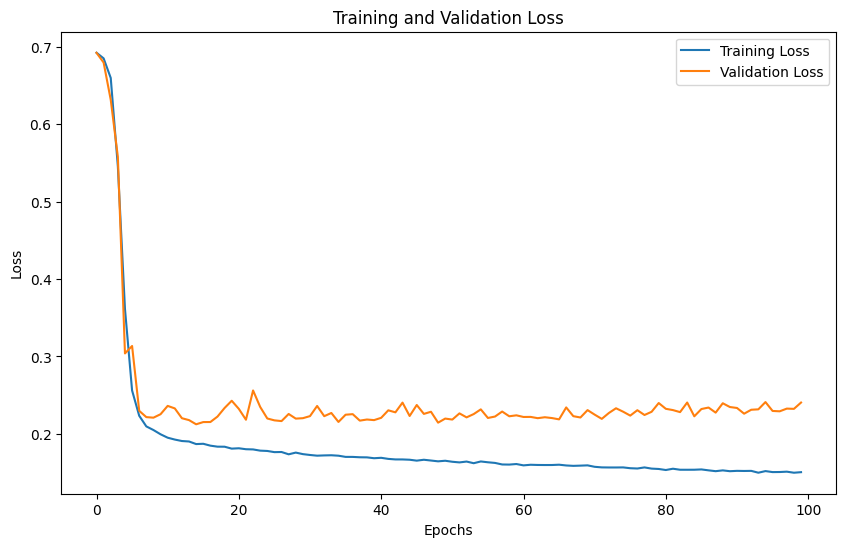

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.9524 - loss: 0.2001
Test Loss: 0.1927, Test Accuracy: 0.9537


In [92]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Load data
X = np.load('Datasets/kryptonite-9-X.npy')
y = np.load('Datasets/kryptonite-9-y.npy')

# Split into train, validation, and test sets (70-15-15 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Define a neural network for binary classification
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model with binary cross-entropy loss and accuracy metric


# Compile the model with SGD
model.compile(optimizer=SGD(learning_rate=(1/11), momentum=0.0), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Plot the loss curves for training and validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set for loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
